# TP1 - 22.45 Redes Neuronales - Regresión Logística y Lineal

## Regresión Logística

### Import required libraries and dataset

In [1]:
from keras.datasets import fashion_mnist
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import datetime
from os.path import exists
tf.config.set_visible_devices([], 'GPU')

2023-05-22 16:51:09.390724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 16:51:09.482234: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-22 16:51:09.857764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tobid/itba/neural-networks/tp1/env/lib
2023-05-22 16:51:09.857813: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfe

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
from numpy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import tensorflow_addons as tfa
from tensorboard.plugins.hparams import api as hp

/home/tobid/itba/neural-networks/tp1/env/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

### Download and load Fashion MNIST dataset

In [5]:
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

### Normalize the dataset

In [6]:
data_max = np.max(train_X)
train_X = train_X.astype('float32') / data_max
test_X = test_X.astype('float32') / data_max
np.max(train_X)

1.0

### Exploratory Data Analysis

#### Example: Show the first object of the train dataset

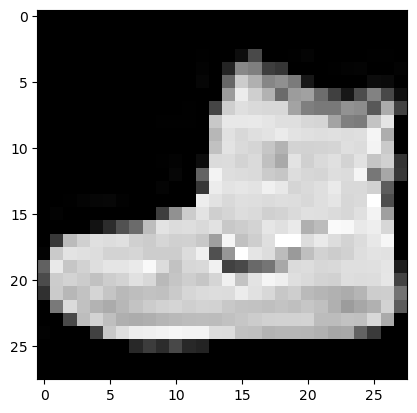

In [7]:
plt.imshow(train_X[0,...], cmap="gray")

#### Show a few instances of each class

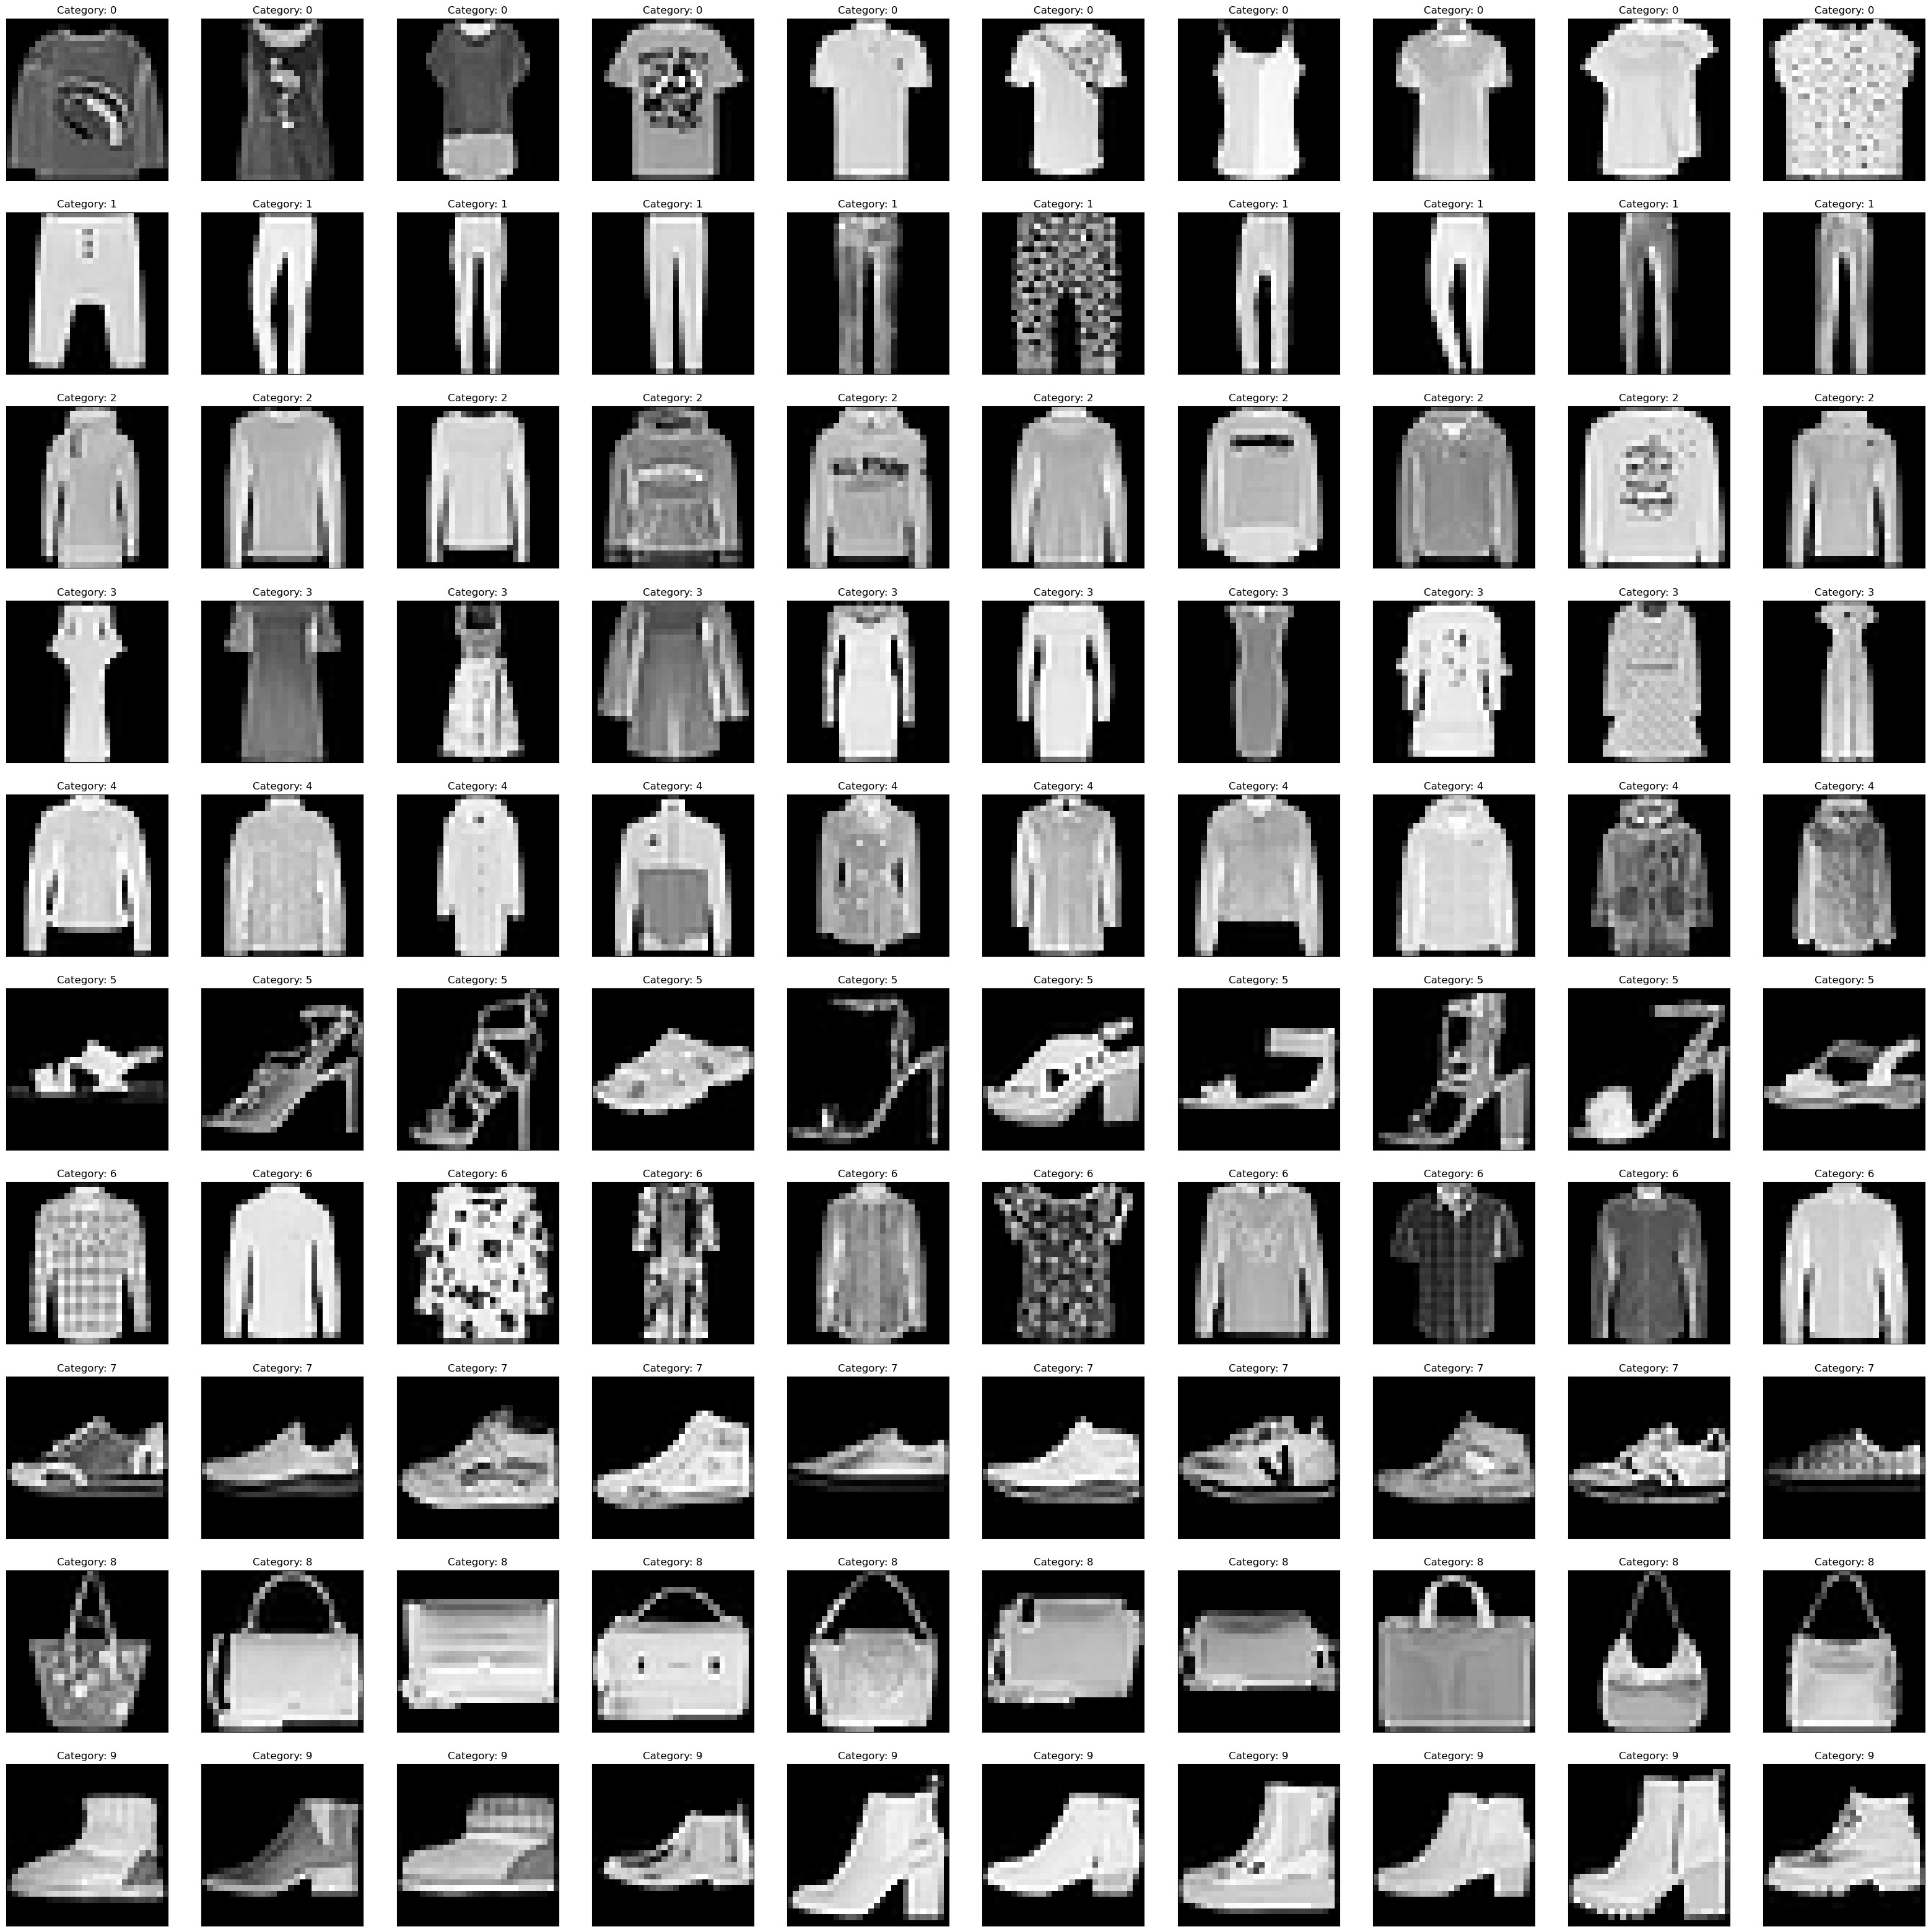

In [8]:
fig = plt.figure(figsize=(40, 40))  # width, height in inches

# idx works on np.array and not lists.
idx = np.argsort(train_y)

train_X_sorted = np.array(train_X)[idx]
train_y_sorted = np.array(train_y)[idx]

count = 0

for i in range(100):
    count = int(np.floor(i / 10))
    sub = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    sub.imshow(train_X_sorted[i + count * 6000,:,:], interpolation='nearest', cmap='gray')
    sub.set_title('Category: ' + str(train_y_sorted[i + count * 6000]))

#### Look at the data distribution

##### Training data

{0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


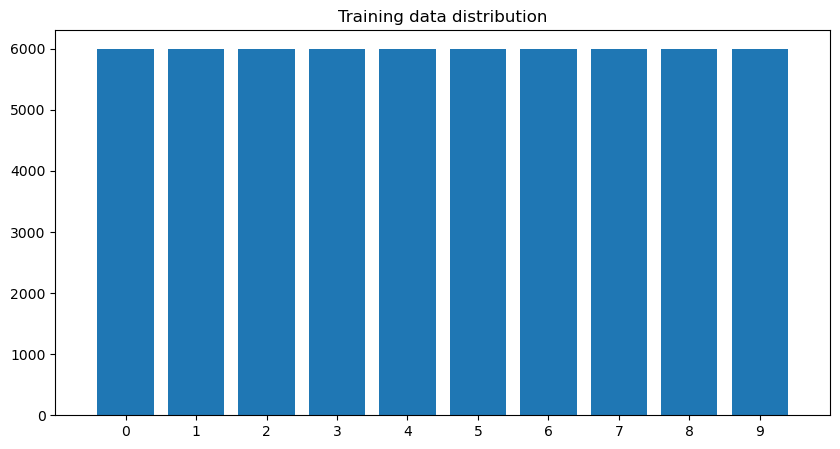

In [9]:
unique, counts = np.unique(train_y, return_counts=True)
print(dict(zip(unique, counts)))

counts = np.bincount(train_y)
print(counts)

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(range(10), counts, width=0.8, align='center')
ax.set(xticks=range(10), xlim=[-1, 10], title='Training data distribution')

plt.show()

##### Testing data

{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


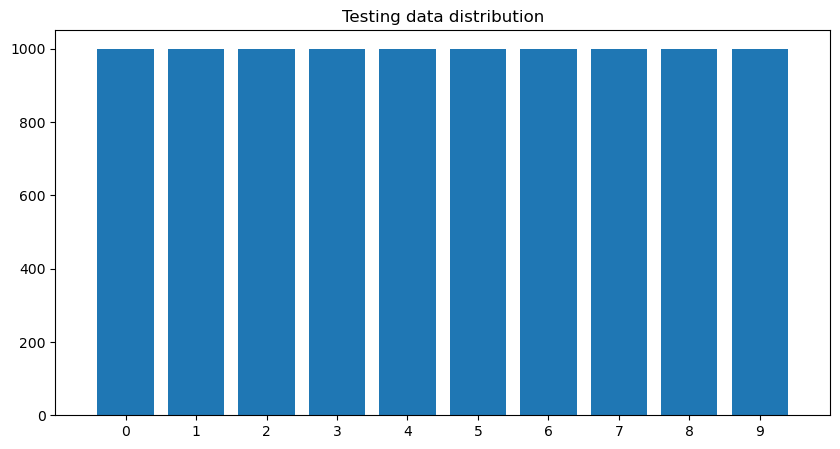

In [10]:
unique, counts = np.unique(test_y, return_counts=True)
print(dict(zip(unique, counts)))

counts = np.bincount(test_y)
print(counts)

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(range(10), counts, width=0.8, align='center')
ax.set(xticks=range(10), xlim=[-1, 10], title='Testing data distribution')

plt.show()

### Convert the dataset from a vector form to a categorical distribution

In [11]:
num_classes = np.max(train_y) + 1
train_y_cat = utils.to_categorical(train_y, num_classes)
test_y_cat = utils.to_categorical(test_y, num_classes)

### Softmax

#### Define useful callbacks

In [12]:
# Callback to stop training if, after 5 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [13]:
# Callback to save the weights of the best model
checkpoint_filepath_softmax = './checkpoints/softmax/'
model_checkpoint_callback_softmax = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_softmax,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [14]:
# Callback to save logs and metrics for TensorBoard
log_dir_softmax = "logs/fit/softmax/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_softmax = tf.keras.callbacks.TensorBoard(log_dir=log_dir_softmax)

In [15]:
callbacks = [early_stop_callback, tensorboard_callback_softmax, model_checkpoint_callback_softmax]

#### Define and compile the model

In [16]:
softmax_model = Sequential()
softmax_model.add(layers.Flatten(input_shape=(28,28)))
softmax_model.add(layers.Dense(num_classes, activation="softmax", kernel_initializer=tf.keras.initializers.GlorotNormal()))
softmax_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


2023-05-22 16:51:14.661335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
optimizer = optimizers.Adam(learning_rate=0.00093, beta_1=0.95, beta_2=0.94)
metrics = ["accuracy", tfa.metrics.F1Score(average='macro',num_classes=num_classes),tfa.metrics.F1Score(average='micro',num_classes=num_classes, name="f1_score_micro"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
softmax_model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics=metrics)

#### Fit the model to the train data and validate it with the test data

In [18]:
# We load the previously best weights to save time on training
# if (exists(checkpoint_filepath_softmax)):
#    softmax_model.load_weights(checkpoint_filepath_softmax)

In [19]:
softmax_history = softmax_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 32, epochs=100, callbacks=callbacks)

Epoch 1/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5869 - accuracy: 0.8002 - f1_score: 0.7968 - f1_score_micro: 0.8002 - precision: 0.8683 - recall: 0.7153 - val_loss: 0.5026 - val_accuracy: 0.8301 - val_f1_score: 0.8287 - val_f1_score_micro: 0.8301 - val_precision: 0.8745 - val_recall: 0.7814
Epoch 2/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4609 - accuracy: 0.8439 - f1_score: 0.8426 - f1_score_micro: 0.8439 - precision: 0.8818 - recall: 0.8028 - val_loss: 0.4941 - val_accuracy: 0.8302 - val_f1_score: 0.8323 - val_f1_score_micro: 0.8302 - val_precision: 0.8669 - val_recall: 0.7929
Epoch 3/100
1875/1875 [==============================] - 2s 960us/step - loss: 0.4402 - accuracy: 0.8502 - f1_score: 0.8493 - f1_score_micro: 0.8502 - precision: 0.8839 - recall: 0.8158 - val_loss: 0.4662 - val_accuracy: 0.8425 - val_f1_score: 0.8410 - val_f1_score_micro: 0.8425 - val_precision: 0.8771 - val_recall: 0.8096
Epoch 4/100
1875/1875 [======

#### Plot important metrics

##### TensorBoard session

In [20]:
%tensorboard --logdir $log_dir_softmax

##### Loss

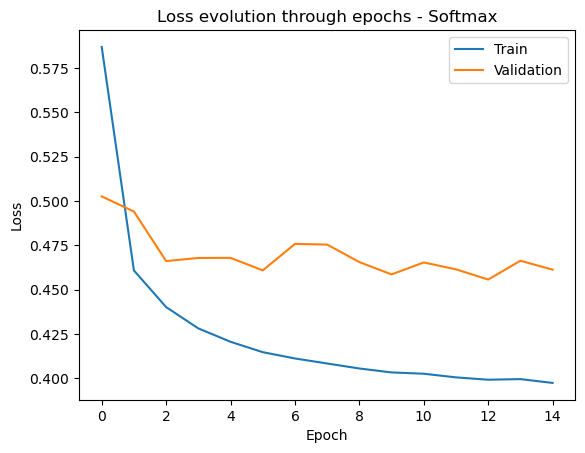

In [21]:
plt.plot(softmax_history.history["loss"], label="Train")
plt.plot(softmax_history.history["val_loss"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss evolution through epochs - Softmax')
plt.show()

##### Accuracy

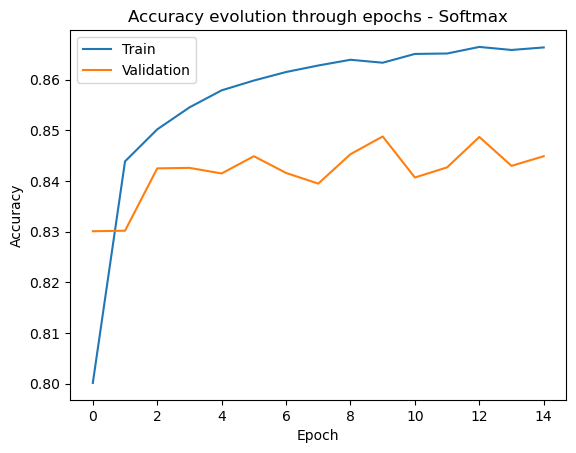

In [22]:
plt.plot(softmax_history.history["accuracy"], label="Train")
plt.plot(softmax_history.history["val_accuracy"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy evolution through epochs - Softmax')
plt.show()

##### Precision

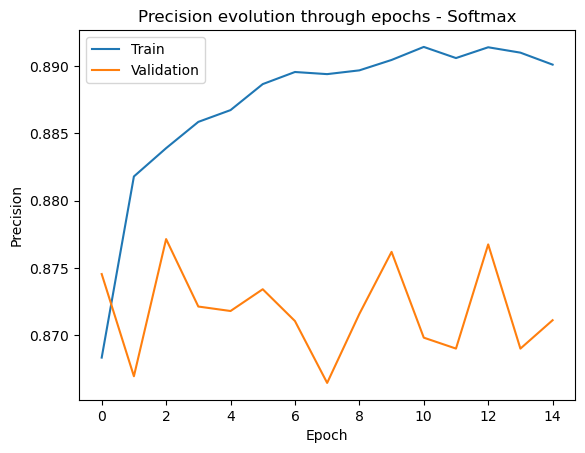

In [23]:
plt.plot(softmax_history.history["precision"], label="Train")
plt.plot(softmax_history.history["val_precision"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision evolution through epochs - Softmax')
plt.show()

##### Recall

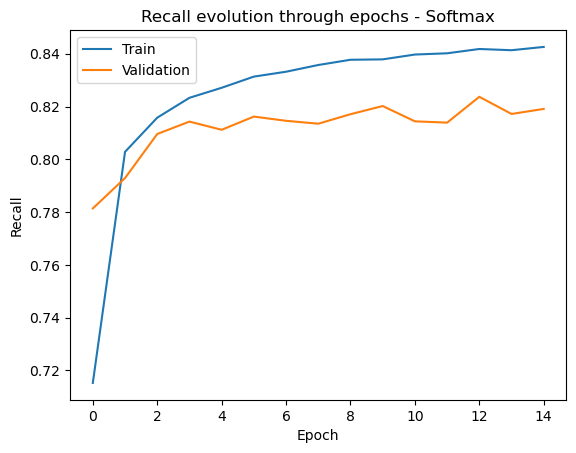

In [24]:
plt.plot(softmax_history.history["recall"], label="Train")
plt.plot(softmax_history.history["val_recall"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall evolution through epochs - Softmax')
plt.show()

##### F1-Score

###### Macro

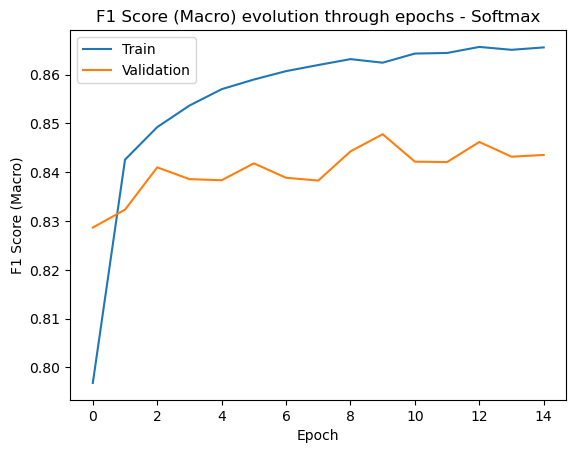

In [25]:
plt.plot(softmax_history.history["f1_score"], label="Train")
plt.plot(softmax_history.history["val_f1_score"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Macro)')
plt.title('F1 Score (Macro) evolution through epochs - Softmax')
plt.show()

###### Micro

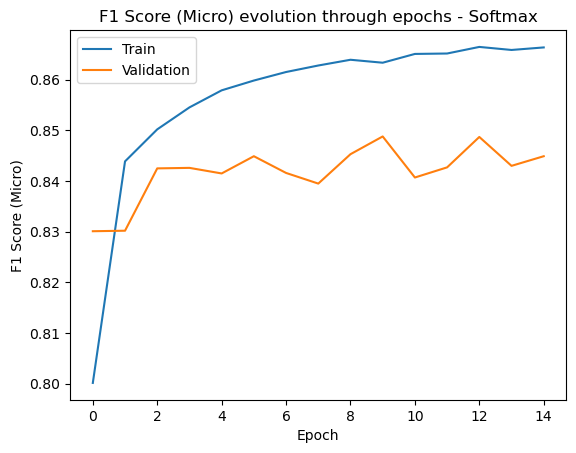

In [26]:
plt.plot(softmax_history.history["f1_score_micro"], label="Train")
plt.plot(softmax_history.history["val_f1_score_micro"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Micro)')
plt.title('F1 Score (Micro) evolution through epochs - Softmax')
plt.show()

En este problema los F1 Score tanto macro como micro son muy similares a causa de que no existe desbalance de clases.

##### ROC and AUC

313/313 [==============================] - 0s 592us/step


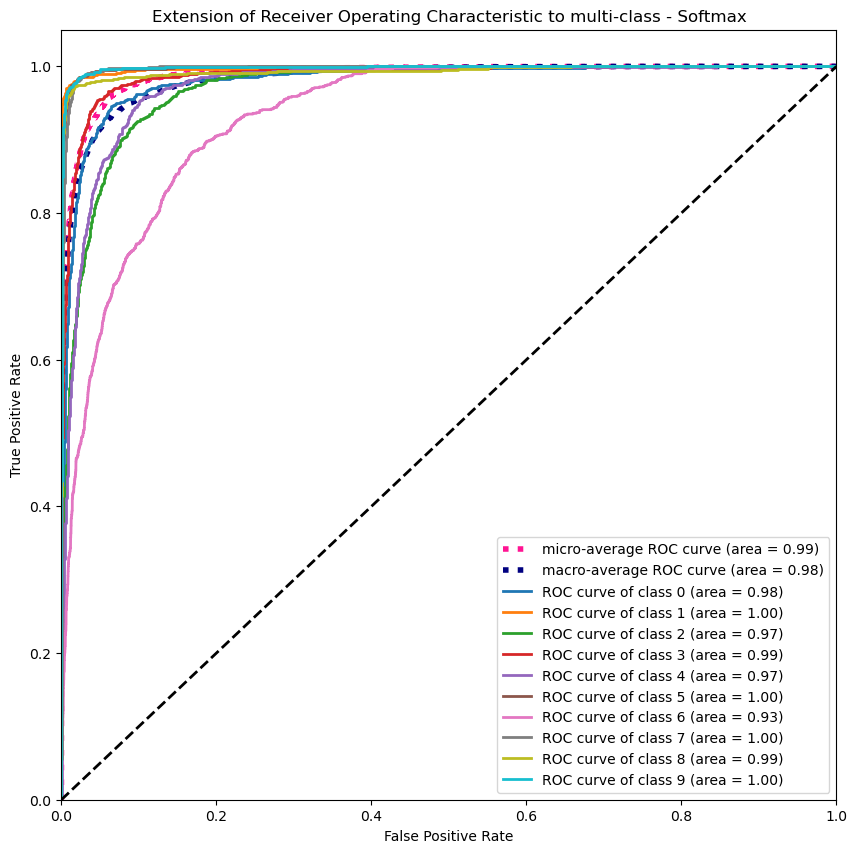

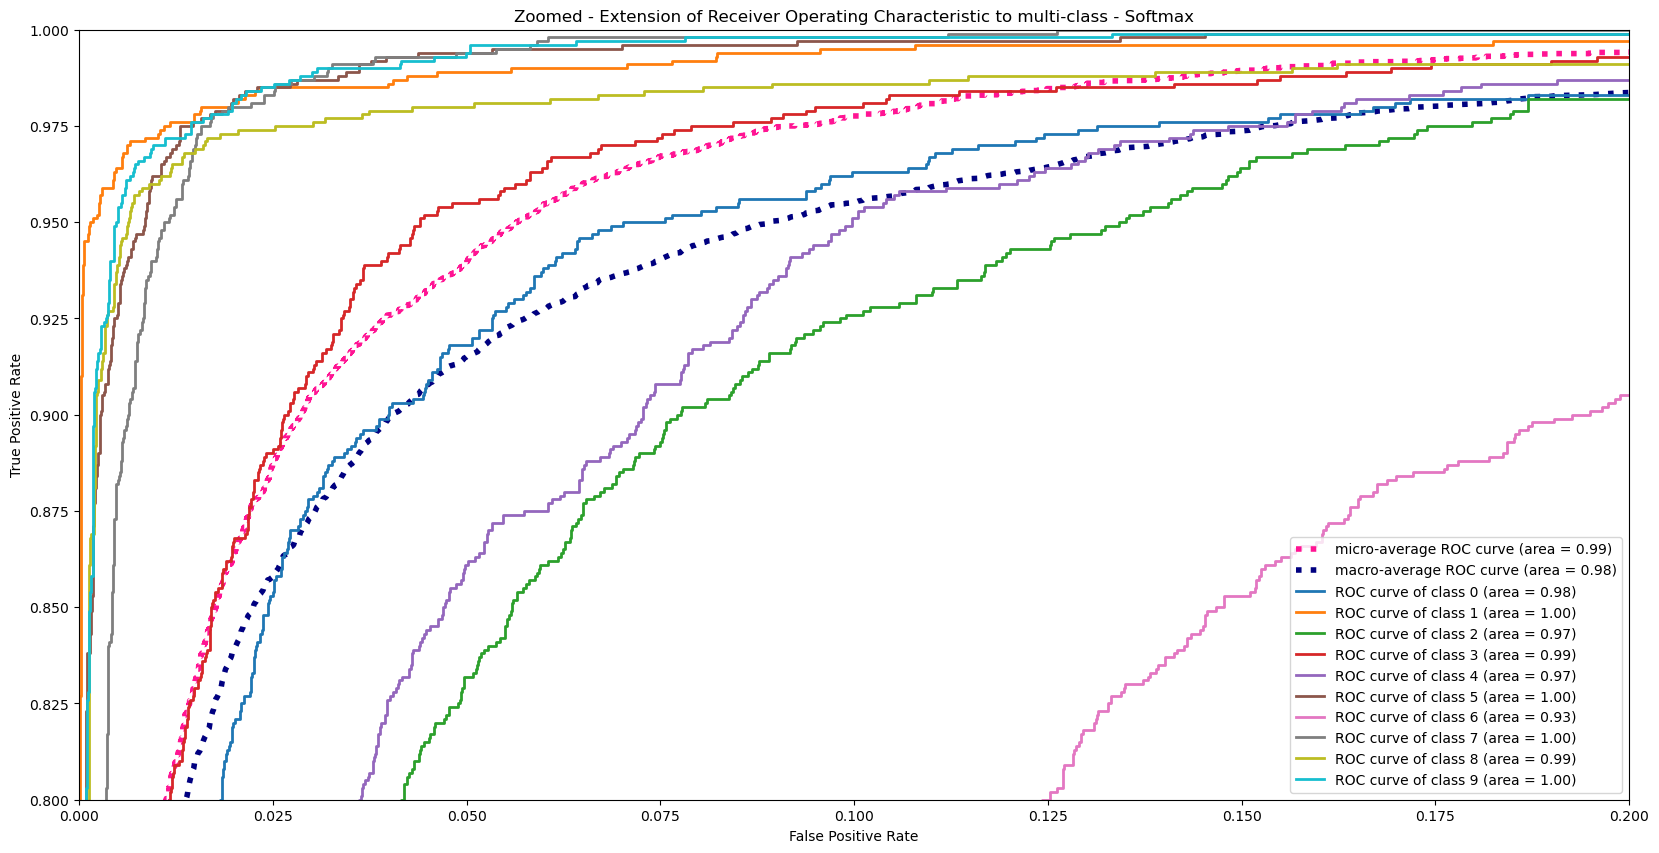

In [27]:
# Plot linewidth.
lw = 2

# Get score
y_score = softmax_model.predict(test_X)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y_cat[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y_cat.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1, figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver Operating Characteristic to multi-class - Softmax')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2, figsize=(20,10))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

    
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed - Extension of Receiver Operating Characteristic to multi-class - Softmax')
plt.legend(loc="lower right")
plt.show()

Al igual que para el F1 Score, las curvas ROC tanto macro como micro dan muy similares porque no hay desbalance de clases.

### MLP

#### Define useful callbacks

In [28]:
# Callback to stop training if, after 10 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

In [29]:
# Callback to save the weights of the best model
checkpoint_filepath_mlp = './checkpoints/mlp/'
model_checkpoint_callback_mlp = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_mlp,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [30]:
# Callback to save logs and metrics for TensorBoard
log_dir_mlp = "logs/fit/mlp/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_mlp = tf.keras.callbacks.TensorBoard(log_dir=log_dir_mlp)

In [31]:
callbacks = [early_stop_callback, tensorboard_callback_mlp, model_checkpoint_callback_mlp]

#### Define and compile the model

In [32]:
mlp_model = Sequential()
mlp_model.add(layers.Flatten(input_shape=(28,28)))
mlp_model.add(layers.BatchNormalization())
mlp_model.add(layers.Dense(512, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
mlp_model.add(layers.Dense(num_classes, activation="softmax"))
mlp_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               401920    
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                      

In [33]:
optimizer = optimizers.Nadam(learning_rate=0.00112, beta_1=0.9, beta_2=0.98)
metrics = ["accuracy", tfa.metrics.F1Score(average='macro',num_classes=num_classes),tfa.metrics.F1Score(average='micro',num_classes=num_classes, name="f1_score_micro"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
mlp_model.compile(loss = 'log_cosh', optimizer=optimizer, metrics=metrics)

#### Fit the model to the train data and validate it with the test data

In [34]:
# We load the previously best weights to save time on training
# if (exists(checkpoint_filepath_mlp)):
#    mlp_model.load_weights(checkpoint_filepath_mlp)

In [35]:
mlp_history = mlp_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 32, epochs=100, callbacks=callbacks)

Epoch 1/100
1875/1875 [==============================] - 6s 2ms/step - loss: 0.0126 - accuracy: 0.8075 - f1_score: 0.8052 - f1_score_micro: 0.8075 - precision: 0.8505 - recall: 0.7723 - val_loss: 0.0102 - val_accuracy: 0.8471 - val_f1_score: 0.8441 - val_f1_score_micro: 0.8471 - val_precision: 0.8690 - val_recall: 0.8276
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0097 - accuracy: 0.8550 - f1_score: 0.8540 - f1_score_micro: 0.8550 - precision: 0.8805 - recall: 0.8328 - val_loss: 0.0095 - val_accuracy: 0.8568 - val_f1_score: 0.8559 - val_f1_score_micro: 0.8568 - val_precision: 0.8796 - val_recall: 0.8383
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - accuracy: 0.8678 - f1_score: 0.8672 - f1_score_micro: 0.8678 - precision: 0.8916 - recall: 0.8469 - val_loss: 0.0091 - val_accuracy: 0.8660 - val_f1_score: 0.8660 - val_f1_score_micro: 0.8660 - val_precision: 0.8845 - val_recall: 0.8506
Epoch 4/100
1875/1875 [========

#### Plot important metrics

##### TensorBoard session

In [36]:
%tensorboard --logdir $log_dir_mlp

##### Loss

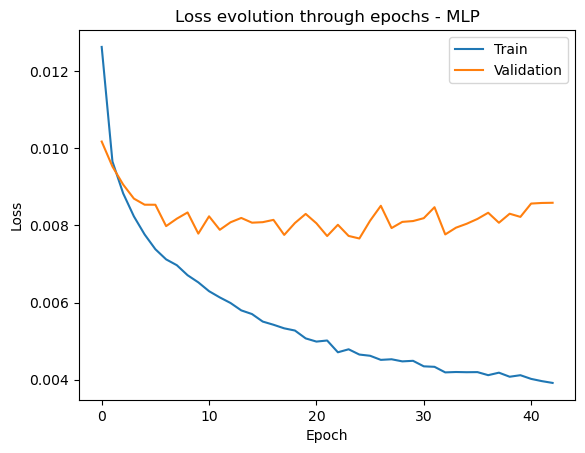

In [37]:
plt.plot(mlp_history.history["loss"], label="Train")
plt.plot(mlp_history.history["val_loss"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss evolution through epochs - MLP')
plt.show()

Observamos en el loss el overfitting de la red neuronal a medida que aumentamos el entrenamiento.

##### Accuracy

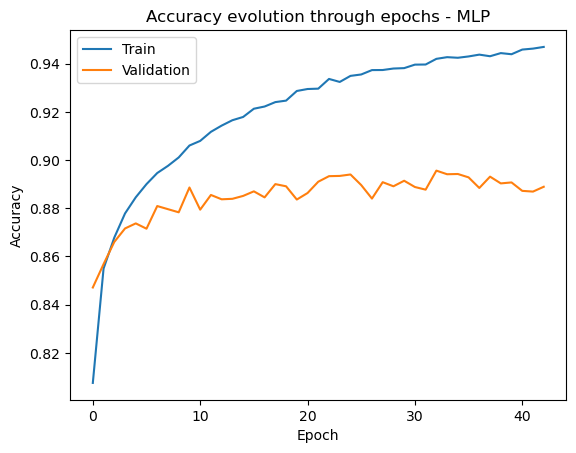

In [38]:
plt.plot(mlp_history.history["accuracy"], label="Train")
plt.plot(mlp_history.history["val_accuracy"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy evolution through epochs - MLP')
plt.show()

##### Precision

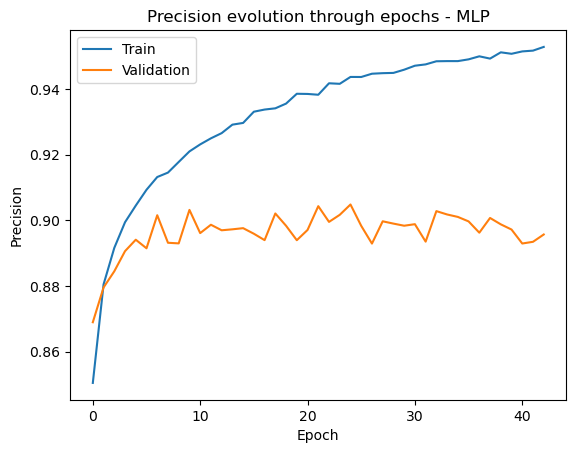

In [39]:
plt.plot(mlp_history.history["precision"], label="Train")
plt.plot(mlp_history.history["val_precision"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision evolution through epochs - MLP')
plt.show()

##### Recall

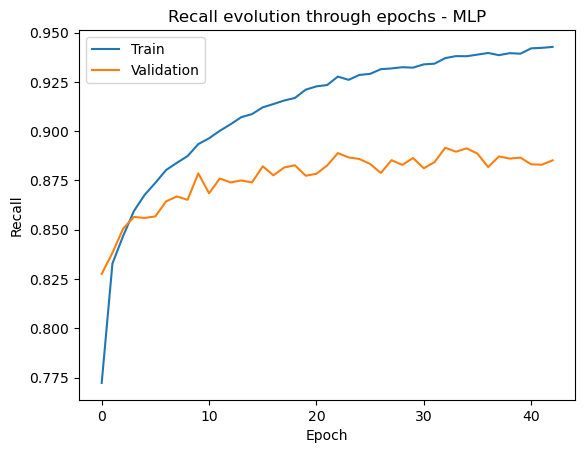

In [40]:
plt.plot(mlp_history.history["recall"], label="Train")
plt.plot(mlp_history.history["val_recall"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall evolution through epochs - MLP')
plt.show()

##### F1-Score

###### Macro

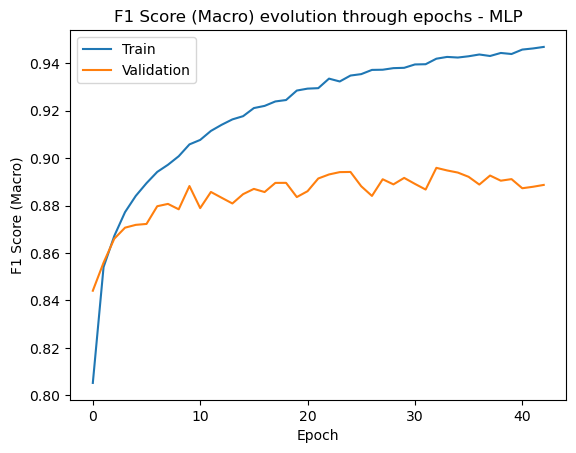

In [41]:
plt.plot(mlp_history.history["f1_score"], label="Train")
plt.plot(mlp_history.history["val_f1_score"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Macro)')
plt.title('F1 Score (Macro) evolution through epochs - MLP')
plt.show()

###### Micro

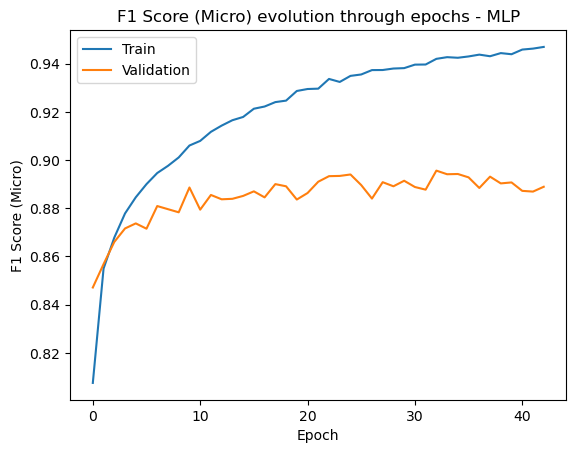

In [42]:
plt.plot(mlp_history.history["f1_score_micro"], label="Train")
plt.plot(mlp_history.history["val_f1_score_micro"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Micro)')
plt.title('F1 Score (Micro) evolution through epochs - MLP')
plt.show()

En este problema los F1 Score tanto macro como micro son muy similares a causa de que no existe desbalance de clases.

##### ROC and AUC

313/313 [==============================] - 0s 813us/step


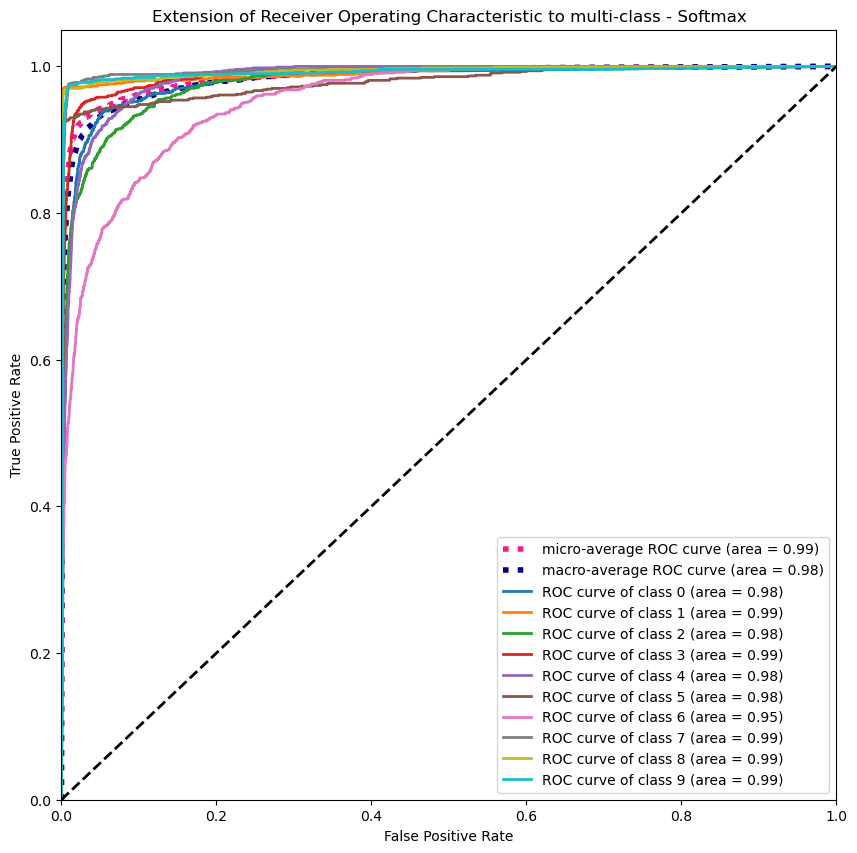

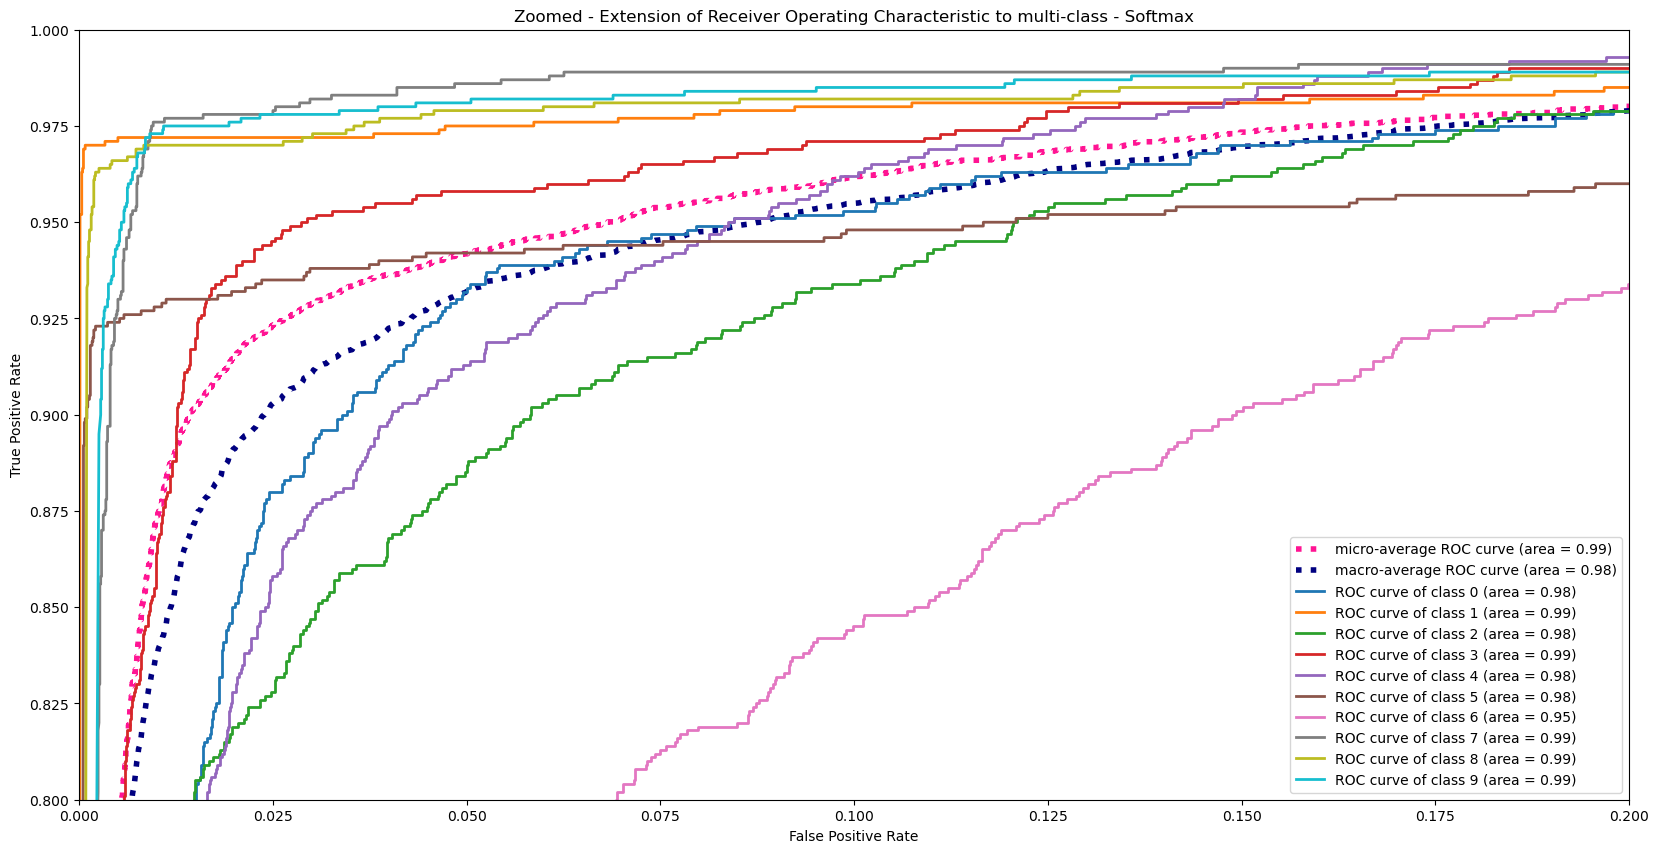

In [43]:
# Plot linewidth.
lw = 2

# Get score
y_score = mlp_model.predict(test_X)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y_cat[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y_cat.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1, figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver Operating Characteristic to multi-class - Softmax')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2, figsize=(20,10))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

    
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed - Extension of Receiver Operating Characteristic to multi-class - Softmax')
plt.legend(loc="lower right")
plt.show()

Al igual que para el F1 Score, las curvas ROC tanto macro como micro dan muy similares porque no hay desbalance de clases.